In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from scipy.stats import t
from scipy.stats import norm

In [5]:
from sklearn.preprocessing import PowerTransformer

In [6]:
from statsmodels.graphics.gofplots import qqplot

#### t dist

In [7]:
t_series = pd.Series(fn.gen_rv(t, args=[3, 0], size = 100))
norm_series = pd.Series(fn.gen_rv(norm, args=[0, 1], size = 100))

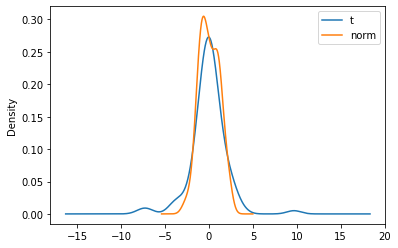

In [8]:
fig, ax = plt.subplots()
t_series.plot.kde(label='t')
norm_series.plot.kde(label='norm')
ax.legend()

#### Test for normality

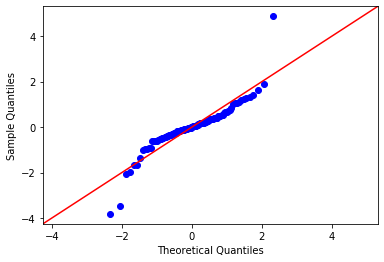

In [9]:
fig = qqplot(t_series, fit=True, line='45')
plt.show()

In [10]:
st.shapiro_wilks_(t_series)

Statistics=0.866, p=0.000
Sample does not look Gaussian (reject H0)


In [11]:
st.jarque_bera_(t_series)

Statistics=216.476, p=0.000, skew=0.138, kurt=10.203
Sample does not look Gaussian (reject H0)


#### Individual control chart

In [12]:
in_control_mean = t_series.mean()

In [13]:
MR  = cp.calculate_MR(t_series)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [14]:
in_control_mean, in_control_sigma

(-0.04346843123956872, 1.748034101035023)

In [15]:
x_ind_params = cp.x_ind_params(x = t_series, sigma = in_control_sigma, center=in_control_mean)

In [16]:
x_ind_params = x_ind_params.reset_index()

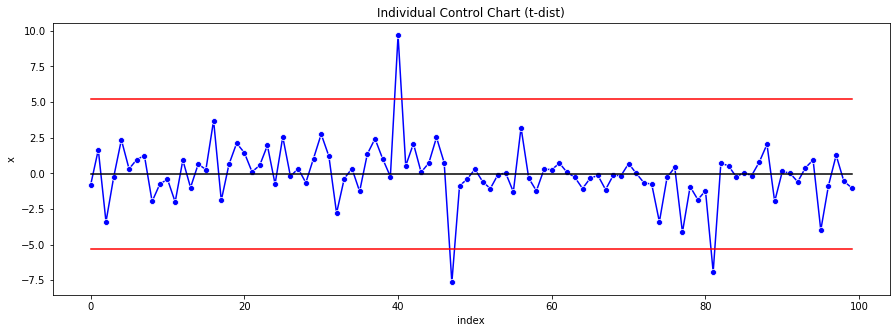

In [17]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title='Individual Control Chart (t-dist)',
    ylab='x',
    xlab=None,
    all_dates=False,
    rot=0)

#### Transform t dist

In [18]:
pt = PowerTransformer(method='yeo-johnson', standardize=False, copy=True)

In [19]:
pt_fitted = pt.fit(t_series.values.reshape(-1, 1))

In [20]:
t_series_transformed = pd.Series(pt_fitted.transform(t_series.values.reshape(-1, 1)).flatten())

In [21]:
lambda_bc = pt_fitted.lambdas_

In [22]:
lambda_bc

array([1.00394278])

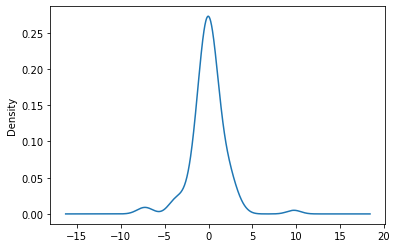

In [23]:
t_series_transformed.plot.kde()

#### Test for normality

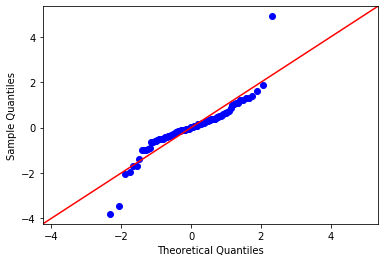

In [24]:
fig = qqplot(t_series_transformed, fit=True, line='45')
plt.show()

In [25]:
st.shapiro_wilks_(t_series_transformed)

Statistics=0.866, p=0.000
Sample does not look Gaussian (reject H0)


In [26]:
st.jarque_bera_(t_series_transformed)

Statistics=220.576, p=0.000, skew=0.177, kurt=10.267
Sample does not look Gaussian (reject H0)


#### Individual control chart (transformed)

In [27]:
in_control_mean = t_series_transformed.mean()

In [28]:
MR  = cp.calculate_MR(t_series_transformed)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [29]:
in_control_mean, in_control_sigma

(-0.039667759001763295, 1.7475947614797873)

In [30]:
x_ind_params = cp.x_ind_params(x = t_series_transformed, sigma = in_control_sigma, center=in_control_mean, L=3)

In [31]:
x_ind_params = x_ind_params.reset_index()

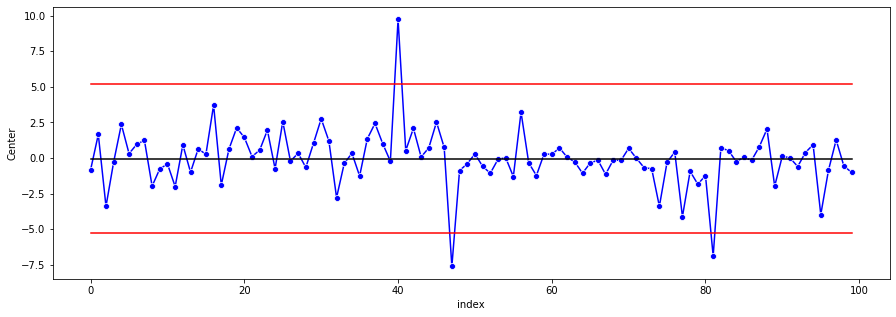

In [32]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title=None,
    ylab=None,
    xlab=None,
    all_dates=False,
    rot=0)

#### Check probability (adjust control limits)

In [33]:
df = list(range(3, 31))

In [34]:
mean, var, skew, kurt = t.stats(df, moments='mvsk')

In [35]:
sigma1 = 1 * np.sqrt(var)
sigma2 = 2 * np.sqrt(var)
sigma3 = 3 * np.sqrt(var)
sigma4 = 4 * np.sqrt(var)
sigma5 = 5 * np.sqrt(var)
sigma6 = 6 * np.sqrt(var)

In [36]:
def coverage(CL, df):
    n_sigma = CL * t.std(df=df, loc=0, scale=1)
    ret = (1 - (1 - t.cdf(n_sigma, df=df, loc=0, scale=1)) * 2) * 100
    return ret

In [37]:
t_df = pd.DataFrame({'df':df,
                     'skew':skew,
                     'kurt':kurt,
                     'sigma1':sigma1,
                     'sigma2':sigma2,
                     'sigma3':sigma3,
                     'sigma4':sigma4,
                     'sigma5':sigma5,
                     'sigma6':sigma6,
                     '1-sigma control (t)':coverage(1, df),
                     '2-sigma control (t)':coverage(2, df),
                     '3-sigma control (t)':coverage(3, df),
                     '3.5-sigma control (t)':coverage(3.5, df),
                     '4-sigma control (t)':coverage(4, df),
                     '5-sigma control (t)':coverage(5, df),
                     '6-sigma control (t)':coverage(6, df)
                  })

In [38]:
t_df['3-sigma control (norm)'] = (1 - (1 - norm.cdf(3)) * 2 ) * 100

In [39]:
t_df_sub = t_df.loc[:, ['df', 
                        '3-sigma control (t)',
#                         '3.5-sigma control (t)',
                        '4-sigma control (t)', 
                        '5-sigma control (t)', 
                        '6-sigma control (t)',
                        '3-sigma control (norm)']]

In [40]:
t_df_sub_melt = pd.melt(t_df_sub, id_vars=['df'])

In [41]:
# t_df_sub

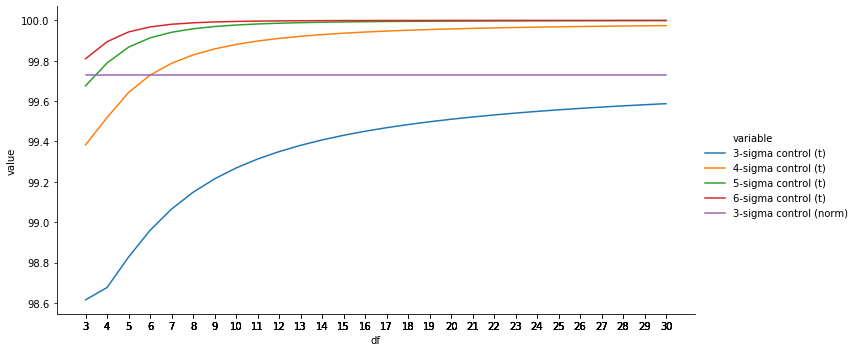

In [42]:
g = sns.relplot(x='df', y='value', hue='variable', data=t_df_sub_melt, kind='line', height=5, aspect=2)
g.set(xticks=t_df_sub_melt.df.values)